In [1]:
import os

import numpy as np

from pyspark.sql import functions as F

from fink_utils.spark.utils import concat_col

from fink_filters.classification import extract_fink_classification

from fink_science import __file__
from fink_science.hostless_detection.processor import run_potential_hostless

/opt/spark-3/python/pyspark/sql/pandas/functions.py:399: UserWarning: In Python 3.6+ and Spark 3.0+, it is preferred to specify type hints for pandas UDF instead of specifying pandas UDF type which will be deprecated in the future releases. See SPARK-28264 for more details.
  warnings.warn(
/opt/spark-3/python/pyspark/sql/pandas/functions.py:399: UserWarning: In Python 3.6+ and Spark 3.0+, it is preferred to specify type hints for pandas UDF instead of specifying pandas UDF type which will be deprecated in the future releases. See SPARK-28264 for more details.
  warnings.warn(
/opt/spark-3/python/pyspark/sql/pandas/functions.py:399: UserWarning: In Python 3.6+ and Spark 3.0+, it is preferred to specify type hints for pandas UDF instead of specifying pandas UDF type which will be deprecated in the future releases. See SPARK-28264 for more details.
  warnings.warn(


In [2]:
# check https://fink-portal.org/stats for number of alerts per night
# rule of thumb: about 2min processing for 150k incoming alerts
df = spark.read.format('parquet').load('/user/julien.peloton/archive/science/year=2024/month=07/day=03')

24/08/01 21:17:10 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [3]:
# Retrieve time-series information
to_expand = ["magpsf"]

# Append temp columns with historical + current measurements
prefix = "c"
for colname in to_expand:
    df = concat_col(df, colname, prefix=prefix)

# Add classification
cols = [
    "cdsxmatch",
    "roid",
    "mulens",
    "snn_snia_vs_nonia",
    "snn_sn_vs_all",
    "rf_snia_vs_nonia",
    "candidate.ndethist",
    "candidate.drb",
    "candidate.classtar",
    "candidate.jd",
    "candidate.jdstarthist",
    "rf_kn_vs_nonkn",
    "tracklet",
]
df = df.withColumn("finkclass", extract_fink_classification(*cols))

# Add TNS classification -- fake for the moment
df = df.withColumn("tnsclass", F.lit("Unknown"))

# Add a new column
df = df.withColumn(
    "kstest_static",
    run_potential_hostless(
        df["cmagpsf"],
        df["cutoutScience.stampData"],
        df["cutoutTemplate.stampData"],
        df["snn_snia_vs_nonia"],
        df["snn_sn_vs_all"],
        df["rf_snia_vs_nonia"],
        df["rf_kn_vs_nonkn"],
        df["finkclass"],
        df["tnsclass"],
    ),
)

cols_ = [
    "objectId",
    "candidate.candid",
    "candidate.ra",
    "candidate.dec",
    "kstest_static",
    "finkclass",
    "tnsclass",
]

In [4]:
pdf = df.filter(df["kstest_static"] >= 0).select(cols_).toPandas()

## Inspect objects with p > 0.5

In [6]:
cond = pdf['kstest_static'] > 0.5

In [7]:
# hyperlinks
def make_clickable(val):
    if isinstance(val, str) and val.startswith('https'):
        return '<a href="{}" target="_blank">{}</a>'.format(val,val)
    else:
        return val

pdf['link'] = pdf['objectId'].apply(lambda x: "https://fink-portal.org/{}".format(x))

In [8]:
pdf[cond].style.format(make_clickable)

,objectId,candid,ra,dec,kstest_static,finkclass,tnsclass,link
30,ZTF24aatkhem,2740464224215015008,10.4167253,41.0889359,0.9720603227615356,SN candidate,Unknown,https://fink-portal.org/ZTF24aatkhem
32,ZTF21aaeklcv,2740279035415010003,236.0524739,35.6793517,0.9328643083572388,QSO,Unknown,https://fink-portal.org/ZTF21aaeklcv
43,ZTF24aakzgdx,2740359461915015011,314.3541633,17.1282602,0.9601256251335144,SN candidate,Unknown,https://fink-portal.org/ZTF24aakzgdx
51,ZTF24aakajtn,2740310062415015017,277.3991144,39.8539871,0.7202261090278625,Ambiguous,Unknown,https://fink-portal.org/ZTF24aakajtn
55,ZTF19aasbgti,2740226013515010006,216.1296592,33.3993399,0.5330150723457336,QSO,Unknown,https://fink-portal.org/ZTF19aasbgti
56,ZTF24aaowjlw,2740228875515015006,227.5384667,6.7517049,0.5710803866386414,Ambiguous,Unknown,https://fink-portal.org/ZTF24aaowjlw
57,ZTF19aalexbk,2740283555015010001,279.7213208,64.5399733,0.9290452003479004,QSO,Unknown,https://fink-portal.org/ZTF19aalexbk
60,ZTF24aaowjlw,2740233395515015021,227.5384588,6.7516818,0.7418844103813171,Ambiguous,Unknown,https://fink-portal.org/ZTF24aaowjlw
63,ZTF18aayagtm,2740279032815010000,232.9445569,32.9527269,0.6627889275550842,QSO,Unknown,https://fink-portal.org/ZTF18aayagtm
72,ZTF24aakajtn,2740345752415015023,277.3991432,39.8540027,0.6275628209114075,Ambiguous,Unknown,https://fink-portal.org/ZTF24aakajtn


## Inspect templates

ZTF24aatkhem: 0.97


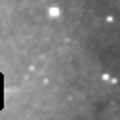

ZTF21aaeklcv: 0.93


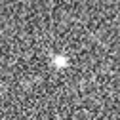

ZTF24aakzgdx: 0.96


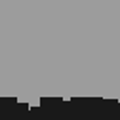

ZTF24aakajtn: 0.72


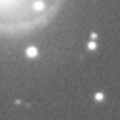

ZTF19aasbgti: 0.53


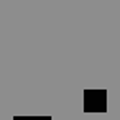

ZTF24aaowjlw: 0.57


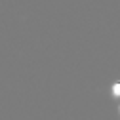

ZTF19aalexbk: 0.93


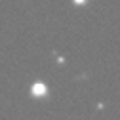

ZTF24aaowjlw: 0.74


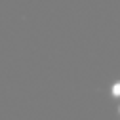

ZTF18aayagtm: 0.66


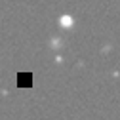

ZTF24aakajtn: 0.63


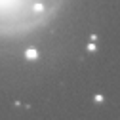

ZTF18aauenwu: 0.95


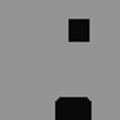

ZTF19aasbrme: 0.51


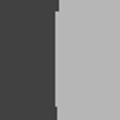

ZTF19abkncst: 0.74


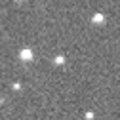

ZTF18aabybkt: 0.91


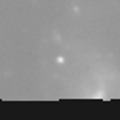

ZTF21abcwutj: 0.59


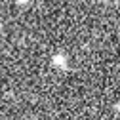

ZTF24aatkhem: 0.98


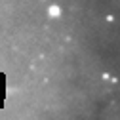

ZTF18abnyhxn: 0.85


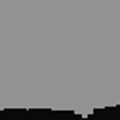

In [65]:
import io
import requests
from PIL import Image as im
import time

objectIds = pdf[cond]["objectId"]
candids = pdf[cond]["candid"]
scores = pdf[cond]['kstest_static']
for objid, candid, score in zip(objectIds, candids, scores):
    print("{}: {:.2f}".format(objid, score))
    r = requests.post(
        'https://fink-portal.org/api/v1/cutouts',
        json={
            'objectId': objid,
            'candid': candid,
            'kind': 'Template',
        }
    )

    image = im.open(io.BytesIO(r.content))
    display(image.resize((120, 120)))
